In [21]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

device = "cuda:7"

In [3]:
import torchvision.transforms as T
CIFAR10_STATS = {
    'mean' : [0.4914, 0.4822, 0.4465],
    'std' : [0.2023, 0.1994, 0.2010]
}

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(CIFAR10_STATS['mean'], CIFAR10_STATS['std'])
            ])

valid_dataset = torchvision.datasets.CIFAR10(root='/data8/donghun/cifar10/untracked/', train=False, transform=transform)
# valid_dataset = torchvision.datasets.CIFAR10(root='/root/data/cifar10', train=False, transform=transform)
# interpolation = torch.from_numpy(np.load('/root/results/cifar10/image_simple_gradient_ascent_interpolation.npy'))

# interpolation.shape
model = torch.jit.load("/data8/donghun/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to(device)
# model = torch.load("/root/data/cifar10/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to('cuda:0')


In [20]:
bottleneck = torch.load("/home/dhlee/code/ig_inversion/ig_pkg/bottleneck_ae/results/cifar10_8/model_best.pt",  map_location='cpu').eval().to(device)

ModuleNotFoundError: No module named 'autoencoder_modules'

In [ ]:
def image_gradient(model, y, baseline, device, **kwrags): 

    model.zero_grad()
    baseline = baseline.to(device)
    
    X = Variable(baseline.unsqueeze(0), requires_grad=True).to(device)
    X.retain_grad()
    
    output = model(X,)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(X.size(0), output.size()[-1]).zero_().to(device).type(X.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)

    gradient = X.grad  #Approximate the integral using the trapezoidal rule

    return gradient

image domain -1, -0.5, 0, 0.5, 1

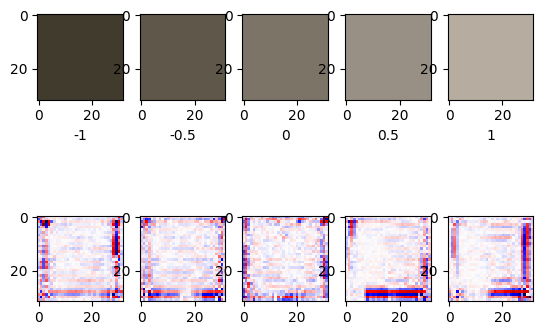

In [18]:
from ig_pkg.utils.attribution import image_heatmap
# image_baseline = []
# coeff = [-1, -0.5, 0, 0.5, 1]
# for i in range(5):
#     temp = torch.ones((3, 32, 32)) * coeff[i]
#     print(torch.mean(temp))
#     image_baseline.append(temp)
    
# image_baseline = torch.stack(image_baseline)
# print(image_baseline.shape)

fig, axes = plt.subplots(2, 5)
axes_flat = axes.flat

label_image_baseline = []
for i in range(5):
    temp = image_baseline[i]
    ax = next(axes_flat)
    ax.imshow(convert_to_img(temp))
    ax.set_xlabel(f'{coeff[i]}')
    
    temp_label = torch.argmax(model(temp.unsqueeze(0).to(device)), dim=-1)
    label_image_baseline.append(temp_label.item())

# out, grad = image_heatmap(model, x, y, temp, interpolation, device, **kwrags): 

for i in range(5):    
    grad = image_gradient(model, label_image_baseline[i], image_baseline[i], device)    
    attr = grad.squeeze(0)
    attr = attr.mean(axis=0)    
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    

In [23]:
latent_baseline = [[ 0.9790, -0.5944,  0.9840,  0.3247, -0.9923, -0.8754, -0.6798,  0.6908],
 [ 0.9657, -0.4447,  0.9570,  0.1508, -0.9633, -0.8206, -0.5215,  0.3061],
 [-0.0722, -0.1693,  0.1727, -0.0027,  0.0215, -0.0958, -0.0955, -0.0293],
 [ 0.9618, -0.3241,  0.8949,  0.0161, -0.7720, -0.8048, -0.1046, -0.4961],
 [ 0.9800, -0.0379,  0.8815, -0.1404, -0.6166, -0.8239,  0.1591, -0.8084]]

pca = [[ 0.01552928,  0.571816, -0.03334171, -0.40915,  0.1417619, 0.08252704,  0.2810632 , -0.63116264], 
    [-0.06604326, -0.18297149,  0.04879477,  0.7596098 , -0.00115259, -0.06883926,  0.28585574, -0.544351]]


In [30]:
tm = np.array(pca)
tm.T.shape

(8, 2)

In [39]:
np.linalg.lstsq(np.array(pca).T, np.array(latent_baseline).T, rcond=None)[0]

array([[-1.33033185, -0.87695201, -0.11578975, -0.09895174,  0.42114534],
       [-0.17019533, -0.07926448,  0.03734161,  0.3481205 ,  0.4215359 ]])

In [ ]:
device = 'cuda:0'
names = {
    'zero',
    'one',
    'min',
    'max',
    'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

# {'gaussian',
#  'gaussian_blur',
#  'max',
#  'maximumdistance',
#  'min',
#  'one',
#  'scalar',
#  'uniform',
#  'zero'}

index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

AOPC = []
LODDs = []
Kendal = []
for name in names:
    print(name)
    a = []
    b = []
    try:
        b_generator =  get_baseline_generator(name, scalar = 0.3)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(eval_mode.to(device), x, y, baseline, device=device)
    Kendal.append(kendal_correlation(eval_mode, ferrot_tensor, baseline, attr.detach().cpu().numpy(), device))

#     print(name)
    for i in range(19):
#         k = i * 5 + 5        
        k = i + 1
        aopc, lodds = pipeline(eval_mode, ferrot_tensor.to(device), baseline, attr, k, device, name)
        
#         print(name, k, aopc, lodds)
        a.append(aopc)
        b.append(lodds)
    
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
    
    AOPC.append(a)
    LODDs.append(b)    
    
plt.tight_layout()